In [1]:
# import tensorflow as tf
# import keras
import pandas as pd
import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import lightgbm as lgb
# import xgboost as xgb
import time
import datetime
# from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
# from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
from tqdm import tqdm_notebook
import seaborn as sns

from sklearn.model_selection import train_test_split

import pickle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score

In [374]:
pd.set_option('display.max_columns', None)

In [635]:
players = pd.read_csv('/home/ryan/ml/tennis_ml/tennis_atp/atp_players.csv', 
                      header=None, 
                      names=['player_id', 'first_name', 'last_name', 'hand', 'birthday','country_code'])

In [636]:
players

,player_id,first_name,last_name,hand,birthday,country_code
0,100001,Gardnar,Mulloy,R,19131122.0,USA
1,100002,Pancho,Segura,R,19210620.0,ECU
2,100003,Frank,Sedgman,R,19271002.0,AUS
3,100004,Giuseppe,Merlo,R,19271011.0,ITA
4,100005,Richard Pancho,Gonzales,R,19280509.0,USA
...,...,...,...,...,...,...
54892,209858,Vladimir,Osminkin,U,NaN,RUS
54893,209859,Rostislav,Galfinger,U,20021112.0,KAZ
54894,209860,Ignacio,Buse,U,20040325.0,PER
54895,209861,Maj,Tomac,U,20010504.0,SLO


In [637]:
#read all CSVs here and concatenate to form one dataframe
# df = pd.read_csv('/home/ryan/ml/tennis_ml/tennis_atp/atp_matches_2019.csv')

#enter years form which to take data: [start, end]
years = [2000, 2020]
df = pd.DataFrame()

for year in np.arange(years[0], years[1]+1):
    df_year = pd.read_csv(f'/home/ryan/ml/tennis_ml/tennis_atp/atp_matches_{year}.csv')
    df = pd.concat([df,df_year])

In [638]:
df.columns = ['tourney_id','tourney_name', 'surface', 'draw_size', 'tourney_level', 'tourney_date', 'match_num', 'w_id', 'w_seed', 'w_entry', 'w_name', 'w_hand', 'w_ht',
              'w_ioc', 'w_age', 'l_id', 'l_seed', 'l_entry', 'l_name', 'l_hand', 'l_ht', 'l_ioc', 'l_age', 'score', 'best_of', 'round', 'minutes',
              'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved',
              'l_bpFaced', 'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points']

In [639]:
list(df.columns.values)

['tourney_id',
 'tourney_name',
 'surface',
 'draw_size',
 'tourney_level',
 'tourney_date',
 'match_num',
 'w_id',
 'w_seed',
 'w_entry',
 'w_name',
 'w_hand',
 'w_ht',
 'w_ioc',
 'w_age',
 'l_id',
 'l_seed',
 'l_entry',
 'l_name',
 'l_hand',
 'l_ht',
 'l_ioc',
 'l_age',
 'score',
 'best_of',
 'round',
 'minutes',
 'w_ace',
 'w_df',
 'w_svpt',
 'w_1stIn',
 'w_1stWon',
 'w_2ndWon',
 'w_SvGms',
 'w_bpSaved',
 'w_bpFaced',
 'l_ace',
 'l_df',
 'l_svpt',
 'l_1stIn',
 'l_1stWon',
 'l_2ndWon',
 'l_SvGms',
 'l_bpSaved',
 'l_bpFaced',
 'winner_rank',
 'winner_rank_points',
 'loser_rank',
 'loser_rank_points']

In [640]:
df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,w_id,w_seed,w_entry,w_name,w_hand,w_ht,w_ioc,w_age,l_id,l_seed,l_entry,l_name,l_hand,l_ht,l_ioc,l_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2000-301,Auckland,Hard,32,A,20000110,1,103163,1,NaN,Tommy Haas,R,188.0,GER,21.771389,101543,NaN,NaN,Jeff Tarango,L,180.0,USA,31.137577,7-5 4-6 7-5,3,R32,108.0,18.0,4.0,96.0,49.0,39.0,28.0,17.0,3.0,5.0,7.0,8.0,106.0,55.0,39.0,29.0,17.0,4.0,7.0,11.0,1612.0,63.0,595.0
1,2000-301,Auckland,Hard,32,A,20000110,2,102607,NaN,Q,Juan Balcells,R,190.0,ESP,24.558522,102644,NaN,NaN,Franco Squillari,L,183.0,ARG,24.386037,7-5 7-5,3,R32,85.0,5.0,3.0,76.0,52.0,39.0,13.0,12.0,5.0,6.0,5.0,10.0,74.0,32.0,25.0,18.0,12.0,3.0,6.0,211.0,157.0,49.0,723.0
2,2000-301,Auckland,Hard,32,A,20000110,3,103252,NaN,NaN,Alberto Martin,R,175.0,ESP,21.390828,102238,NaN,NaN,Alberto Berasategui,R,173.0,ESP,26.535250,6-3 6-1,3,R32,56.0,0.0,0.0,55.0,35.0,25.0,12.0,8.0,1.0,1.0,0.0,6.0,56.0,33.0,20.0,7.0,8.0,7.0,11.0,48.0,726.0,59.0,649.0
3,2000-301,Auckland,Hard,32,A,20000110,4,103507,7,NaN,Juan Carlos Ferrero,R,183.0,ESP,19.909651,103819,NaN,NaN,Roger Federer,R,185.0,SUI,18.422998,6-4 6-4,3,R32,68.0,5.0,1.0,53.0,28.0,26.0,15.0,10.0,0.0,0.0,11.0,2.0,70.0,43.0,29.0,14.0,10.0,6.0,8.0,45.0,768.0,61.0,616.0
4,2000-301,Auckland,Hard,32,A,20000110,5,102103,NaN,Q,Michael Sell,R,180.0,USA,27.381246,102765,4,NaN,Nicolas Escude,R,185.0,FRA,23.770021,0-6 7-6(7) 6-1,3,R32,115.0,1.0,2.0,98.0,66.0,39.0,14.0,13.0,6.0,11.0,8.0,8.0,92.0,46.0,34.0,18.0,12.0,5.0,9.0,167.0,219.0,34.0,873.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2020-6932,Rio De Janeiro,Clay,32,A,20200217,274,106426,3,NaN,Christian Garin,R,NaN,CHI,23.718001,105413,NaN,NaN,Andrej Martin,R,180.0,SVK,30.409309,4-6 7-5 7-6(5),3,R32,189.0,3.0,5.0,104.0,58.0,44.0,23.0,17.0,4.0,8.0,4.0,3.0,132.0,88.0,56.0,22.0,17.0,12.0,16.0,25.0,1550.0,94.0,629.0
545,2020-6932,Rio De Janeiro,Clay,32,A,20200217,273,106432,5,NaN,Borna Coric,R,NaN,CRO,23.258042,106228,NaN,NaN,Juan Ignacio Londero,R,NaN,ARG,26.507871,7-6(5) 7-5,3,R32,117.0,9.0,2.0,68.0,40.0,32.0,15.0,12.0,0.0,2.0,0.0,3.0,80.0,49.0,34.0,16.0,12.0,7.0,10.0,32.0,1320.0,61.0,881.0
546,2020-6932,Rio De Janeiro,Clay,32,A,20200217,272,205734,NaN,WC,Thiago Seyboth Wild,R,NaN,BRA,19.939767,200221,NaN,NaN,Alejandro Davidovich Fokina,R,NaN,ESP,20.703628,5-7 7-6(3) 7-5,3,R32,229.0,5.0,6.0,132.0,67.0,44.0,30.0,18.0,6.0,12.0,1.0,2.0,159.0,104.0,61.0,27.0,18.0,15.0,21.0,206.0,235.0,90.0,655.0
547,2020-6932,Rio De Janeiro,Clay,32,A,20200217,271,132283,NaN,NaN,Lorenzo Sonego,R,NaN,ITA,24.772074,104919,NaN,NaN,Leonardo Mayer,R,188.0,ARG,32.761123,6-1 5-7 6-4,3,R32,171.0,6.0,4.0,99.0,57.0,40.0,25.0,15.0,6.0,7.0,0.0,11.0,91.0,45.0,28.0,26.0,14.0,3.0,6.0,52.0,960.0,109.0,509.0


#### create player dictionary

In [641]:
#unique ids in the csv
ids = pd.concat([df['w_id'], df['l_id']]).unique()

In [ ]:
###iterate through player ids and collect features

#instantiate a new dictionary to keep track of player stats
#this will be useful for diffing them later to create input-target pairs
pid_dict = {}
    
for target_pid in tqdm_notebook(ids):
    ### get features from whether the target player won or lost
    df2 = df[(df.loc[:,'w_id'] == target_pid ) | (df.loc[:,'l_id'] == target_pid)]

    ###create target column here
    y = [1 if pid==target_pid else 0 for pid in df2.w_id.values]
    y = pd.DataFrame(data=y, columns=['target'])

    ###switch up the dataframe to account for losses since after 
    ###taking target into account, we dont care about winner/loser specific columns
    swapped_features = ['age', 'ht', 'ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']
    for swapFeat in swapped_features:
        df2.loc[(y.target.values == 0), f'w_{swapFeat}'] = df2.loc[(y.target.values == 0), f'l_{swapFeat}']

    ### sort by tournament date and match number so features are sequential/time-dependant
    df2 = df2.sort_values(['tourney_date', 'match_num'], ascending=[True, True])

    ###extract stats from features
    segments = df2.shape[0]
    features = ['surface', 'round', 'w_age', 'w_ht', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced']
    x_tr = extract_stats(df2, segments, features, scale=False)   

    df2.reset_index(drop=True, inplace=True)
    x_tr.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)

    x_tr = pd.concat([df2['tourney_date'], df2['match_num'], y['target'], x_tr], axis=1)

    # ### save to dictionary by PID
    pid_dict.update({f'{target_pid}' : x_tr})

/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: Mean of empty slice.
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice.


In [582]:
# pickle.dump(pid_dict, open( "/home/ryan/ml/tennis_ml/tennis-ml/saved_dictionaries/player_dict_030220.pckl", "wb" ) )
pid_dict = pickle.load( open( "/home/ryan/ml/tennis_ml/tennis-ml/saved_dictionaries/player_dict_030220.pckl", "rb" ) )

In [583]:
pid_dict['103163']

,tourney_date,match_num,target,surface,round,ht,age,ace_mean,ace_std,ace_max,ace_min,ace_mean_change_abs,ace_abs_max,ace_abs_min,max_to_min_diff,sum,q95,q99,q05,q01,abs_q95,abs_q99,abs_q05,abs_q01,mad,kurt,skew,med,ace_ave_roll_std_2,ace_std_roll_std_2,ace_av_change_abs_roll_std_2,ace_av_change_rate_roll_std_2,ace_ave_roll_mean_2,ace_std_roll_mean_2,ace_av_change_abs_roll_mean_2,ace_av_change_rate_roll_mean_2,ace_ave_roll_std_4,ace_std_roll_std_4,ace_av_change_abs_roll_std_4,ace_av_change_rate_roll_std_4,ace_ave_roll_mean_4,ace_std_roll_mean_4,ace_av_change_abs_roll_mean_4,ace_av_change_rate_roll_mean_4,ace_ave_roll_std_8,ace_std_roll_std_8,ace_av_change_abs_roll_std_8,ace_av_change_rate_roll_std_8,ace_ave_roll_mean_8,ace_std_roll_mean_8,ace_av_change_abs_roll_mean_8,ace_av_change_rate_roll_mean_8,ace_ave_roll_std_16,ace_std_roll_std_16,ace_av_change_abs_roll_std_16,ace_av_change_rate_roll_std_16,ace_ave_roll_mean_16,ace_std_roll_mean_16,ace_av_change_abs_roll_mean_16,ace_av_change_rate_roll_mean_16,ace_ave_roll_std_32,ace_std_roll_std_32,ace_av_change_abs_roll_std_32,ace_av_change_rate_roll_std_32,ace_ave_roll_mean_32,ace_std_roll_mean_32,ace_av_change_abs_roll_mean_32,ace_av_change_rate_roll_mean_32,ace_ave_roll_std_64,ace_std_roll_std_64,ace_av_change_abs_roll_std_64,ace_av_change_rate_roll_std_64,ace_ave_roll_mean_64,ace_std_roll_mean_64,ace_av_change_abs_roll_mean_64,ace_av_change_rate_roll_mean_64,df_mean,df_std,df_max,df_min,df_mean_change_abs,df_abs_max,df_abs_min,df_ave_roll_std_2,df_std_roll_std_2,df_av_change_abs_roll_std_2,df_av_change_rate_roll_std_2,df_ave_roll_mean_2,df_std_roll_mean_2,df_av_change_abs_roll_mean_2,df_av_change_rate_roll_mean_2,df_ave_roll_std_4,df_std_roll_std_4,df_av_change_abs_roll_std_4,df_av_change_rate_roll_std_4,df_ave_roll_mean_4,df_std_roll_mean_4,df_av_change_abs_roll_mean_4,df_av_change_rate_roll_mean_4,df_ave_roll_std_8,df_std_roll_std_8,df_av_change_abs_roll_std_8,df_av_change_rate_roll_std_8,df_ave_roll_mean_8,df_std_roll_mean_8,df_av_change_abs_roll_mean_8,df_av_change_rate_roll_mean_8,df_ave_roll_std_16,df_std_roll_std_16,df_av_change_abs_roll_std_16,df_av_change_rate_roll_std_16,df_ave_roll_mean_16,df_std_roll_mean_16,df_av_change_abs_roll_mean_16,df_av_change_rate_roll_mean_16,df_ave_roll_std_32,df_std_roll_std_32,df_av_change_abs_roll_std_32,df_av_change_rate_roll_std_32,df_ave_roll_mean_32,df_std_roll_mean_32,df_av_change_abs_roll_mean_32,df_av_change_rate_roll_mean_32,df_ave_roll_std_64,df_std_roll_std_64,df_av_change_abs_roll_std_64,df_av_change_rate_roll_std_64,df_ave_roll_mean_64,df_std_roll_mean_64,df_av_change_abs_roll_mean_64,df_av_change_rate_roll_mean_64,svpt_mean,svpt_std,svpt_max,svpt_min,svpt_mean_change_abs,svpt_abs_max,svpt_abs_min,svpt_ave_roll_std_2,svpt_std_roll_std_2,svpt_av_change_abs_roll_std_2,svpt_av_change_rate_roll_std_2,svpt_ave_roll_mean_2,svpt_std_roll_mean_2,svpt_av_change_abs_roll_mean_2,svpt_av_change_rate_roll_mean_2,svpt_ave_roll_std_4,svpt_std_roll_std_4,svpt_av_change_abs_roll_std_4,svpt_av_change_rate_roll_std_4,svpt_ave_roll_mean_4,svpt_std_roll_mean_4,svpt_av_change_abs_roll_mean_4,svpt_av_change_rate_roll_mean_4,svpt_ave_roll_std_8,svpt_std_roll_std_8,svpt_av_change_abs_roll_std_8,svpt_av_change_rate_roll_std_8,svpt_ave_roll_mean_8,svpt_std_roll_mean_8,svpt_av_change_abs_roll_mean_8,svpt_av_change_rate_roll_mean_8,svpt_ave_roll_std_16,svpt_std_roll_std_16,svpt_av_change_abs_roll_std_16,svpt_av_change_rate_roll_std_16,svpt_ave_roll_mean_16,svpt_std_roll_mean_16,svpt_av_change_abs_roll_mean_16,svpt_av_change_rate_roll_mean_16,svpt_ave_roll_std_32,svpt_std_roll_std_32,svpt_av_change_abs_roll_std_32,svpt_av_change_rate_roll_std_32,svpt_ave_roll_mean_32,svpt_std_roll_mean_32,svpt_av_change_abs_roll_mean_32,svpt_av_change_rate_roll_mean_32,svpt_ave_roll_std_64,svpt_std_roll_std_64,svpt_av_change_abs_roll_std_64,svpt_av_change_rate_roll_std_64,svpt_ave_roll_mean_64,svpt_std_roll_mean_64,svpt_av_change_abs_roll_mean_64,svpt_av_change_rate_roll_mea

In [528]:
#pickle out the player dicitonary
# pickle.dump(pid_dict, open( "/home/ryan/ml/tennis_ml/tennis-ml/saved_dictionaries/player_dict_030120.pckl", "wb" ) )
# pid_dict = pickle.load( open( "/home/ryan/ml/tennis_ml/tennis-ml/saved_dictionaries/player_dict_030120.pckl", "rb" ) )

In [9]:
len(pid_dict)

2279

#### create input-target pairs

In [557]:
#tournament date cutoff for validation data
val_tourney_date = 20180501
test_tourney_date = 20190501

#number of rows before/equal to cutoff date
train_rows = (df['tourney_date'] < val_tourney_date).value_counts()[1]
val_rows = ((df['tourney_date'] >= val_tourney_date) & (df['tourney_date'] < test_tourney_date)).value_counts()[1]
test_rows = (df['tourney_date'] >= test_tourney_date).value_counts()[1]

print(f"training samples: {train_rows}")
print(f"val samples: {val_rows}")
print(f"test samples: {test_rows}")

#number of statistical measures taken across features
num_stats = pid_dict['103163'].shape[1]-3
# print(num_stats)

### iterate throught the main dataframe to link up player-ids
### and pull information from the respective dictionary index to form input-target pairs
x_train = np.empty(shape=(int(train_rows*2), num_stats))
y_train = np.empty(shape=(int(train_rows*2), 1))

x_val = np.empty(shape=(int(val_rows*2), num_stats))
y_val = np.empty(shape=(int(val_rows*2), 1))

x_test = np.empty(shape=(int(test_rows*2), num_stats))
y_test = np.empty(shape=(int(test_rows*2), 1))

### get features from whether the target player won or lost
df = df.sort_values(['tourney_date', 'match_num'], ascending=[True, True])

#initialize counters
j = 0
k = 0
l = 0

#loop through each row in the original dataframe
for winner_id, loser_id, tdate, match_num in tqdm_notebook(zip(df.w_id.values, df.l_id.values, df.tourney_date.values, df.match_num.values)):
    
#     try:
    #extract features from player maps
    features_w = np.asarray(pid_dict[f'{winner_id}'].loc[(pid_dict[f'{winner_id}']['tourney_date'] == tdate) & \
                                                         (pid_dict[f'{winner_id}']['match_num'] == match_num)].loc[:, 'surface':])[:1,:]

    features_l = np.asarray(pid_dict[f'{loser_id}'].loc[(pid_dict[f'{loser_id}']['tourney_date'] == tdate) & \
                                                        (pid_dict[f'{loser_id}']['match_num'] == match_num)].loc[:, 'surface':])[:1,:]

    #add to train or validation set based on cutoff date chosen
    if tdate < val_tourney_date:
        ### add to x_train array
        #diff the features from winner to loser and count as a win

        x_train[j,:2] = features_w[0,:2]
        x_train[j,2:] = features_w[0,2:] - features_l[0,2:]
        y_train[j,0] = 1.0

        #diff the features from loser to winner and count as a loss
#         x_train[j+1,:] = features_l - features_w
#         y_train[j+1,0] = 0.0

        x_train[j+1,:2] = features_w[0,:2]
        x_train[j+1,2:] = features_l[0,2:] - features_w[0,2:]
        y_train[j+1,0] = 0.0

        #increment counter
        j+=2
    elif (tdate >= val_tourney_date) & (tdate < test_tourney_date):
        ### add to x_val array
#         x_val[k,:] = features_w - features_l
#         y_val[k,0] = 1.0

        x_val[k,:2] = features_w[0,:2]
        x_val[k,2:] = features_w[0,2:] - features_l[0,2:]
        y_val[k,0] = 1.0

        #diff the features from loser to winner and count as a loss
#         x_val[k+1,:] = features_l - features_w
#         y_val[k+1,0] = 0.0

        x_val[k+1,:2] = features_w[0,:2]
        x_val[k+1,2:] = features_l[0,2:] - features_w[0,2:]
        y_val[k+1,0] = 0.0

        #increment counter
        k+=2
    else:
        ### add to x_val array
#         x_test[l,:] = features_w - features_l
#         y_test[l,0] = 1.0

#         #diff the features from loser to winner and count as a loss
#         x_test[l+1,:] = features_l - features_w
#         y_test[l+1,0] = 0.0

        x_test[l,:2] = features_w[0,:2]
        x_test[l,2:] = features_w[0,2:] - features_l[0,2:]
        y_test[l,0] = 1.0

        x_test[l+1,:2] = features_w[0,:2]
        x_test[l+1,2:] = features_l[0,2:] - features_w[0,2:]
        y_test[l+1,0] = 0.0


        #increment counter
        l+=2
#     except KeyError:
# #             print(e.message)
#         continue

training samples: 57256
val samples: 2734
test samples: 1684


In [ ]:
x_train[0,:]

# LGBM developement

### Random searh for hyperparameter optimization

In [562]:
#random search for hyperparameter optimization
param_test ={'num_leaves': sp_randint(15, 150), 
             'min_child_samples': sp_randint(100, 500), 
             'min_data_in_leaf': sp_randint(20,150), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
             'learning_rate': [0.1, 0.05, 0.01, 0.005],
             'bagging_freq': [3, 4, 5, 6, 7],
             'bagging_fraction': np.linspace(0.6, 0.95, 10)}

fit_params={"early_stopping_rounds": 30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(x_val, y_val[:,0])],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [563]:
#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum

#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 200

clf = lgb.LGBMClassifier(max_depth=-1, 
                         random_state=7, 
                         silent=True, 
                         metric='None', 
                         n_jobs=8, 
                         n_estimators=5000,
                         objective='binary')

gs = RandomizedSearchCV(estimator=clf, 
                        param_distributions=param_test, 
                        n_iter=n_HP_points_to_test,
                        scoring='roc_auc',
                        cv=3,
                        refit=True,
                        random_state=7,
                        verbose=True)

In [564]:
gs.fit(x_train, y_train[:,0], **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid's auc: 0.626897
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.634731
Early stopping, best iteration is:
[82]	valid's auc: 0.638123
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid's auc: 0.578566
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[22]	valid's auc: 0.631926
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid's auc: 0.64192
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid's auc: 0.591905
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid's auc: 0.611501
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid's auc

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 312.3min finished


Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.669033
[200]	valid's auc: 0.681861
[300]	valid's auc: 0.6907
[400]	valid's auc: 0.697355
[500]	valid's auc: 0.701532
[600]	valid's auc: 0.704197
[700]	valid's auc: 0.708104
[800]	valid's auc: 0.711166
Early stopping, best iteration is:
[864]	valid's auc: 0.712533
Best score reached: 0.7467979359492333 with params: {'bagging_fraction': 0.9111111111111111, 'bagging_freq': 6, 'colsample_bytree': 0.7761742766757622, 'learning_rate': 0.05, 'max_depth': 12, 'min_child_samples': 175, 'min_child_weight': 0.01, 'min_data_in_leaf': 75, 'num_leaves': 62, 'reg_alpha': 10, 'reg_lambda': 20, 'subsample': 0.587017932185659} 


In [565]:
print(gs.best_params_)

{'bagging_fraction': 0.9111111111111111, 'bagging_freq': 6, 'colsample_bytree': 0.7761742766757622, 'learning_rate': 0.05, 'max_depth': 12, 'min_child_samples': 175, 'min_child_weight': 0.01, 'min_data_in_leaf': 75, 'num_leaves': 62, 'reg_alpha': 10, 'reg_lambda': 20, 'subsample': 0.587017932185659}


### Train with optimal params

In [ ]:
# using LGBM lib here
# link to original work: https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf

In [566]:
params = {'colsample_bytree': 0.7496764148510038,
          'min_child_samples': 260,
          'min_child_weight': 0.01,
          'min_data_in_leaf': 144,
          'num_leaves': 43,
          'reg_alpha': 7,
          'reg_lambda': 100,
          'subsample': 0.48389072037616415,
          'learning_rate': 0.01} 

# params = {'bagging_fraction': 0.9111111111111111,
#           'bagging_freq': 6,
#           'colsample_bytree': 0.7761742766757622,
#           'learning_rate': 0.05,
#           'max_depth': 12,
#           'min_child_samples': 175,
#           'min_child_weight': 0.01,
#           'min_data_in_leaf': 75,
#           'num_leaves': 62,
#           'reg_alpha': 10,
#           'reg_lambda': 20,
#           'subsample': 0.587017932185659}

model = lgb.LGBMClassifier(**params,
                           n_estimators = 3000,
                           n_jobs = 6, 
                           objective='binary')

model.fit(x_train, y_train[:,0],
          eval_set=[(x_train, y_train[:,0]), (x_val, y_val[:,0])],
          verbose=True,
          early_stopping_rounds=250)

[1]	valid_0's binary_logloss: 0.692464	valid_1's binary_logloss: 0.692666
Training until validation scores don't improve for 250 rounds
[2]	valid_0's binary_logloss: 0.691735	valid_1's binary_logloss: 0.69218
[3]	valid_0's binary_logloss: 0.69103	valid_1's binary_logloss: 0.691708
[4]	valid_0's binary_logloss: 0.690473	valid_1's binary_logloss: 0.691287
[5]	valid_0's binary_logloss: 0.689958	valid_1's binary_logloss: 0.690856
[6]	valid_0's binary_logloss: 0.689211	valid_1's binary_logloss: 0.690282
[7]	valid_0's binary_logloss: 0.688475	valid_1's binary_logloss: 0.689709
[8]	valid_0's binary_logloss: 0.687755	valid_1's binary_logloss: 0.689153
[9]	valid_0's binary_logloss: 0.687035	valid_1's binary_logloss: 0.688617
[10]	valid_0's binary_logloss: 0.686356	valid_1's binary_logloss: 0.688156
[11]	valid_0's binary_logloss: 0.685833	valid_1's binary_logloss: 0.68775
[12]	valid_0's binary_logloss: 0.685264	valid_1's binary_logloss: 0.687412
[13]	valid_0's binary_logloss: 0.684678	valid_1's 

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.7496764148510038, importance_type='split',
               learning_rate=0.01, max_depth=-1, min_child_samples=260,
               min_child_weight=0.01, min_data_in_leaf=144, min_split_gain=0.0,
               n_estimators=3000, n_jobs=6, num_leaves=43, objective='binary',
               random_state=None, reg_alpha=7, reg_lambda=100, silent=True,
               subsample=0.48389072037616415, subsample_for_bin=200000,
               subsample_freq=0)

In [567]:
#validation set prediction @ 0.5 threshold
y_pred_val = model.predict(x_val)
print(f'Validation-set acc: {accuracy_score(y_val, y_pred_val)*100:0.2f}%')

Validation-set acc: 63.95%


In [568]:
#validation set prediction @ 0.5 threshold
y_pred_test = model.predict(x_test)
print(f'Hold-out Test-set acc: {accuracy_score(y_test, y_pred_test)*100:0.2f}%')

Hold-out Test-set acc: 60.96%


# Evaluation

#### ROC Curve to determine threshold

In [569]:
y_pred_val = model.predict_proba(x_val)[:,1]
y_pred_test = model.predict_proba(x_test)[:,1]

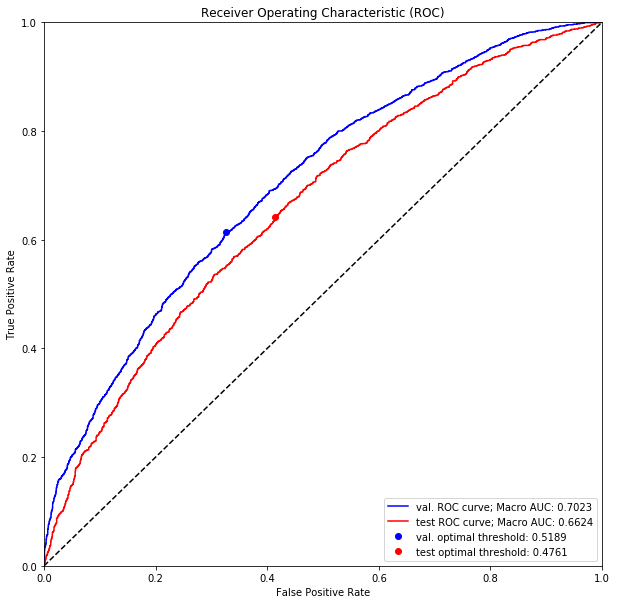

In [570]:
# Compute fpr, tpr, thresholds and roc auc
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_pred_val)
mac_roc_auc_val = roc_auc_score(y_val, y_pred_val, average='macro')

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
mac_roc_auc_test = roc_auc_score(y_test, y_pred_test, average='macro')

#optimal threshold from ROC curve
#minimum euclid distance between (0,1) threshold points
min_arg_val = np.argmin(euclid_distance(fpr_val, tpr_val, opt_point=(0,1)))
opt_thres_val = thresholds_val[min_arg_val]

min_arg_test = np.argmin(euclid_distance(fpr_test, tpr_test, opt_point=(0,1)))
opt_thres_test = thresholds_test[min_arg_test]

# Plot ROC curve
plt.figure(figsize=(10,10))
plt.plot(fpr_val, tpr_val,'b', label=f'val. ROC curve; Macro AUC: {mac_roc_auc_val:0.4f}')
plt.plot(fpr_test, tpr_test, 'r', label=f'test ROC curve; Macro AUC: {mac_roc_auc_test:0.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.plot(fpr_val[min_arg_val], tpr_val[min_arg_val], 'bo', label=f'val. optimal threshold: {opt_thres_val:0.4f}')
plt.plot(fpr_test[min_arg_test], tpr_test[min_arg_test], 'ro', label=f'test optimal threshold: {opt_thres_test:0.4f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_pred_bin = y_pred > opt_thres

In [ ]:
print(accuracy_score(y_val, y_pred_bin))

#### Feature importance

In [586]:
#get feature columns
fcols = pid_dict['100644'].loc[:, 'surface':].columns

In [587]:
feature_importance = pd.DataFrame()
fold_importance = pd.DataFrame()
fold_importance["feature"] = fcols
fold_importance["importance"] = model.feature_importances_
feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

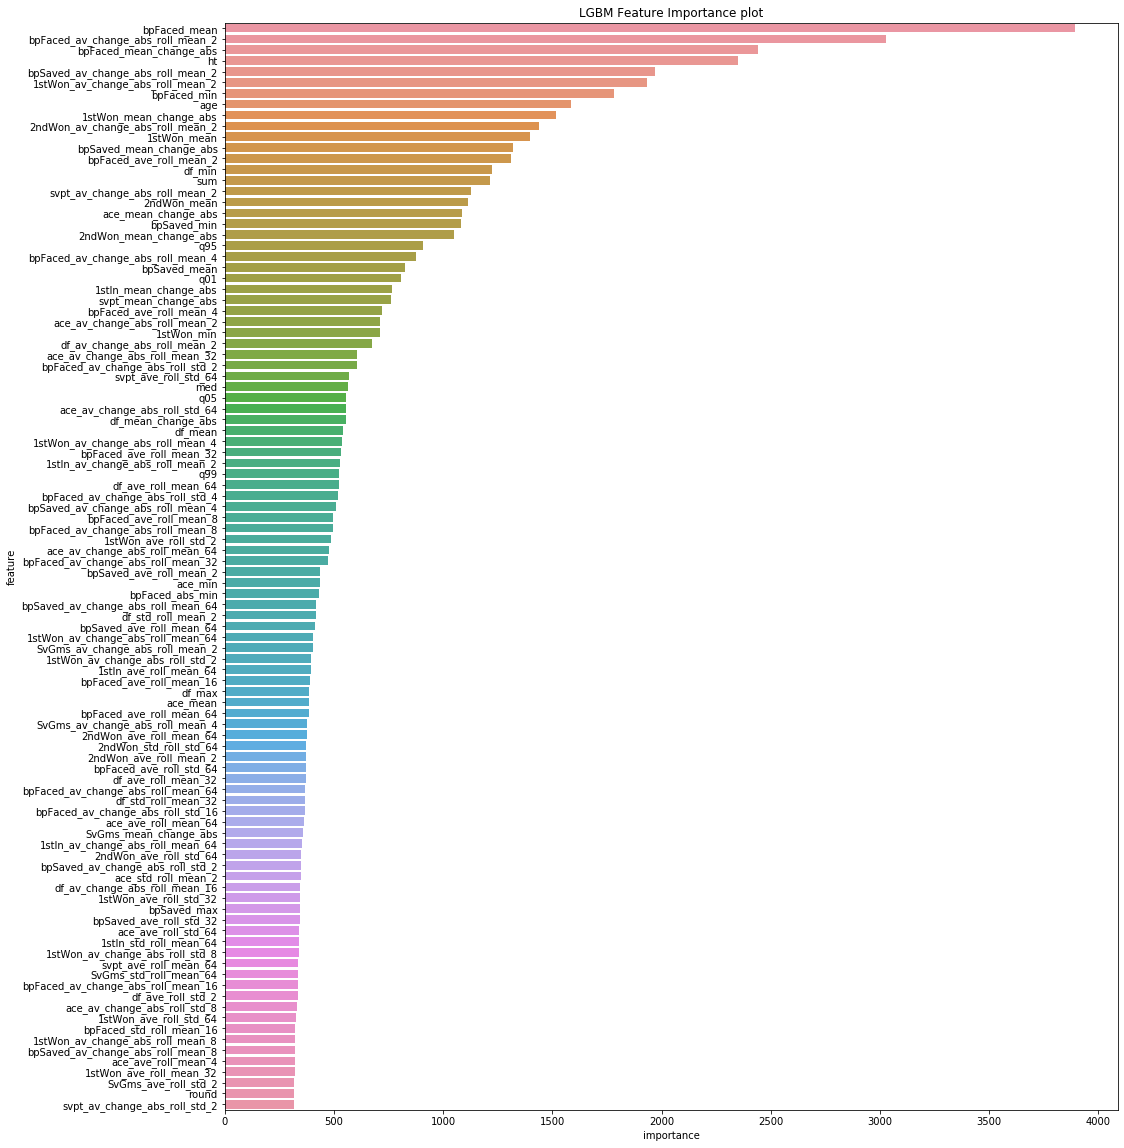

In [588]:
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:100].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 20));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGBM Feature Importance plot');

In [294]:
#get indices of top n columns (im choosing 50 here)
top_cols = np.argsort(-model.feature_importances_)[:100]

In [255]:
# Taking less columns seriously decreases score.
x_train_trim = x_train[:,top_cols]
x_val_trim = x_val[:,top_cols]

model = lgb.LGBMClassifier(**gs.best_params_,
                           n_estimators = 3000,
                           n_jobs = 6, 
                           objective='binary'
                           boosting='gbdt')

model.fit(x_train_trim, y_train[:,0],
          eval_set=[(x_train_trim, y_train[:,0]), (x_val_trim, y_val[:,0])],
          verbose=True)

[1]	valid_0's binary_logloss: 0.68312	valid_1's binary_logloss: 0.684475
[2]	valid_0's binary_logloss: 0.674537	valid_1's binary_logloss: 0.676375
[3]	valid_0's binary_logloss: 0.667217	valid_1's binary_logloss: 0.66941
[4]	valid_0's binary_logloss: 0.661748	valid_1's binary_logloss: 0.663917
[5]	valid_0's binary_logloss: 0.656132	valid_1's binary_logloss: 0.65851
[6]	valid_0's binary_logloss: 0.651161	valid_1's binary_logloss: 0.654379
[7]	valid_0's binary_logloss: 0.646984	valid_1's binary_logloss: 0.651203
[8]	valid_0's binary_logloss: 0.643133	valid_1's binary_logloss: 0.64819
[9]	valid_0's binary_logloss: 0.63973	valid_1's binary_logloss: 0.646053
[10]	valid_0's binary_logloss: 0.636597	valid_1's binary_logloss: 0.64381
[11]	valid_0's binary_logloss: 0.633848	valid_1's binary_logloss: 0.64166
[12]	valid_0's binary_logloss: 0.631385	valid_1's binary_logloss: 0.639265
[13]	valid_0's binary_logloss: 0.629149	valid_1's binary_logloss: 0.637206
[14]	valid_0's binary_logloss: 0.627073	v

LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.7496764148510038, importance_type='split',
               learning_rate=0.1, max_depth=-1, min_child_samples=260,
               min_child_weight=0.01, min_data_in_leaf=144, min_split_gain=0.0,
               n_estimators=3000, n_jobs=6, num_leaves=43, objective='binary',
               random_state=None, reg_alpha=7, reg_lambda=100, silent=True,
               subsample=0.48389072037616415, subsample_for_bin=200000,
               subsample_freq=0)

In [256]:
y_pred = model.predict(x_val_trim)
# y_pred = np.expand_dims(y_pred, axis=-1)

In [257]:
print(accuracy_score(y_val, y_pred))

0.6338709677419355


## Real match prediction

#### first retrain model on all data so that its updated on all current player information

In [43]:
#ALL ROWS of full dataframe
dev_rows = df.shape[0]

#number of statistical measures taken across features
num_stats = pid_dict['100644'].shape[1]-3

### iterate throught the main dataframe to link up player-ids
### and pull information from the respective dictionary index to form input-target pairs
x_train_dev = np.empty(shape=(int(dev_rows*2), num_stats))
y_train_dev = np.empty(shape=(int(dev_rows*2), 1))

### get features from whether the target player won or lost
df = df.sort_values(['tourney_date', 'match_num'], ascending=[True, True])

#initialize counters
j = 0

#loop through each row in the original dataframe
for winner_id, loser_id, tdate, match_num in tqdm_notebook(zip(df.winner_id.values, df.loser_id.values, df.tourney_date.values, df.match_num.values)):
    
    #extract features from player maps
    features_w = np.asarray(pid_dict[f'{winner_id}'].loc[(pid_dict[f'{winner_id}']['tourney_date'] == tdate) & (pid_dict[f'{winner_id}']['match_num'] == match_num)].loc[:, 'ace_mean':])[:1,:]
    features_l = np.asarray(pid_dict[f'{loser_id}'].loc[(pid_dict[f'{loser_id}']['tourney_date'] == tdate) & (pid_dict[f'{loser_id}']['match_num'] == match_num)].loc[:, 'ace_mean':])[:1,:]

    ### add to x_train_dev array
    #diff the features from winner to loser and count as a win
    x_train_dev[j,:] = features_w - features_l
    y_train_dev[j,0] = 1.0

    #diff the features from loser to winner and count as a loss
    x_train_dev[j+1,:] = features_l - features_w
    y_train_dev[j+1,0] = 0.0

    #increment counter
    j+=2

In [ ]:
model_dev = lgb.LGBMClassifier(#**gs.best_params_,
                               **params,
                               n_estimators = 5000,
                               n_jobs = 6, 
                               objective='binary',
                               boosting='gbdt')

model_dev.fit(x_train_dev, y_train_dev[:,0],
              eval_set=[(x_train_dev, y_train_dev[:,0])],
              verbose=True,
              early_stopping_rounds=250)

#### Interact here!

In [64]:
# playerA_first_name, playerA_last_name = input("Enter Player 1 [first name(s), last name(s)]: ").split(',')
# playerB_first_name, playerB_last_name = input("Enter Player 2 [first name(s), last name(s)]: ").split(',')

# playerA_first_name = playerA_first_name.capitalize()
# playerA_last_name = playerA_last_name.capitalize()
# playerB_first_name = playerB_first_name.capitalize()
# playerB_last_name = playerB_last_name.capitalize()

Enter Player 1 [first name(s), last name(s)]:  taylor harry, fritz
Enter Player 2 [first name(s), last name(s)]:  test, test test


In [625]:
#round of 16

#real first round score: 6-2
#predicted: 6-3
playerA_first_name, playerA_last_name = 'Rafael', 'Nadal' #correct
playerB_first_name, playerB_last_name = 'Miomir', 'Kecmanovic'
round_ = 'R16'
surface_ = 'HARD'

#real first round score: 6-4
# #predicted: 6-3
# playerA_first_name, playerA_last_name = 'Stanislas', 'Wawrinka' #correct
# playerB_first_name, playerB_last_name = 'Pedro', 'Martinez Portero'

# #real first round score: 4-6
# #predicted: 3-6
# playerA_first_name, playerA_last_name = 'Ugo', 'Humbert' #correct
# playerB_first_name, playerB_last_name = 'Taylor Harry', 'Fritz'
 
# #real first round score: 7-6
# #predicted: 3-6
# playerA_first_name, playerA_last_name = 'Adrian', 'Mannarino' #correct
# playerB_first_name, playerB_last_name = 'Grigor', 'Dimitrov'

# #real first round score: 6-3
# #predicted: 3-6
# playerA_first_name, playerA_last_name = 'Tommy', 'Paul' #correct
# playerB_first_name, playerB_last_name = 'Alexander', 'Zverev'

# #real first round score: 6-3
# #predicted: 6-4
# playerA_first_name, playerA_last_name = 'John', 'Isner' #correct
# playerB_first_name, playerB_last_name = 'Marcos', 'Giron'

# #real first round score: 7-6
# #pred: 4-6
# playerA_first_name, playerA_last_name = 'Soon Woo', 'Kwon' #correct
# playerB_first_name, playerB_last_name = 'Dusan', 'Lajovic'

# #real: 6-4
# #prd: 6-4
# playerA_first_name, playerA_last_name = 'Kyle', 'Edmund' #incorrect
# playerB_first_name, playerB_last_name = 'Felix', 'Auger Aliassime'

# # #Mexican Open quarter finals

# #real: 6-2
# #pred: 6-3
# playerA_first_name, playerA_last_name = 'Rafael', 'Nadal'  #correct
# playerB_first_name, playerB_last_name = 'Soon Woo', 'Kwon'

# #real: 6-4
# #pred: 4-6
# playerA_first_name, playerA_last_name = 'Taylor Harry', 'Fritz' #correct
# playerB_first_name, playerB_last_name = 'Kyle', 'Edmund'

# #real: 4-6
# #pred: 3-6
# playerA_first_name, playerA_last_name = 'Stanislas', 'Wawrinka' #incorrect
# playerB_first_name, playerB_last_name = 'Grigor', 'Dimitrov'

# #real: 7-6
# #pred: 6-3
# playerA_first_name, playerA_last_name = 'John', 'Isner' #correct
# playerB_first_name, playerB_last_name = 'Tommy', 'Paul'

# # #Mexican Open semi finals

# #real: 6-3
# #pred: 6-3
# playerA_first_name, playerA_last_name = 'Rafael', 'Nadal' #correct
# playerB_first_name, playerB_last_name = 'Grigor', 'Dimitrov'

# #real: 6-2
# #pred: 6-3
# playerA_first_name, playerA_last_name = 'John', 'Isner'  #incorrect
# playerB_first_name, playerB_last_name = 'Taylor Harry', 'Fritz'

# # #Mexican Open finals

# #real: 6-3
# #pred: 6-4
# playerA_first_name, playerA_last_name = 'Rafael', 'Nadal' #correct
# playerB_first_name, playerB_last_name = 'Taylor Harry', 'Fritz'

#__________________
# 12 / 15 correct: 80% accurate
#__________________

#other

#real: 5-7
#pred: 6-3
# playerA_first_name, playerA_last_name = 'Casper', 'Ruud' #incorrect
# playerB_first_name, playerB_last_name = 'Thiago', 'Seyboth Wild'

# playerA_first_name, playerA_last_name = 'Arthur', 'Rinderknech'
# playerB_first_name, playerB_last_name = 'Maxime', 'Cressy'

In [631]:
playerA_id = find_id(playerA_first_name, playerA_last_name)
playerB_id = find_id(playerB_first_name, playerB_last_name)

#most recent player A/B tournament date:
tdateA, match_numA = np.asarray(pid_dict[f'{playerA_id}'][['tourney_date', 'match_num']])[-1]
tdateB, match_numB = np.asarray(pid_dict[f'{playerB_id}'][['tourney_date', 'match_num']])[-1]

#gather features from player profile dictionaries
features_a = np.asarray(pid_dict[f'{playerA_id}'].loc[(pid_dict[f'{playerA_id}']['tourney_date'] == tdateA) & (pid_dict[f'{playerA_id}']['match_num'] == match_numA)].loc[:, 'surface':])
features_b = np.asarray(pid_dict[f'{playerB_id}'].loc[(pid_dict[f'{playerB_id}']['tourney_date'] == tdateB) & (pid_dict[f'{playerB_id}']['match_num'] == match_numB)].loc[:, 'surface':])

vect1 = features_a[0,2:] - features_b[0,2:]
vect2 = features_b[0,2:] - features_a[0,2:]

vect1 = np.insert(vect1, 0, get_round_cate(round_), axis=0)
vect1 = np.insert(vect1, 0, get_surface_cate(surface_), axis=0)
vect1 = np.expand_dims(vect1, axis=0)

vect2 = np.insert(vect2, 0, get_round_cate(round_), axis=0)
vect2 = np.insert(vect2, 0, get_surface_cate(surface_), axis=0)
vect2 = np.expand_dims(vect2, axis=0)

#diff the features from a to b
x_dev = np.concatenate((vect1, vect2), axis=0)
print(x_dev.shape)

(2, 513)


In [632]:
# y_pred_dev = model_dev.predict_proba(x_dev)
y_pred_dev = model.predict_proba(x_dev)
y_pred_dev

array([[0.10061473, 0.89938527],
       [0.89469437, 0.10530563]])

In [362]:
y_pred_dev = np.argmax(y_pred_dev, axis=1)
y_pred_dev

array([ 4, 11])

In [633]:
playerA_win_mean = np.mean([y_pred_dev[0][1], y_pred_dev[1][0]])
playerA_win_stdev = np.std([y_pred_dev[0][1], y_pred_dev[1][0]])

playerB_win_mean = np.mean([y_pred_dev[1][1], y_pred_dev[0][0]])
playerB_win_stdev = np.std([y_pred_dev[1][1], y_pred_dev[0][0]])

print(f"Probability that {playerA_first_name} {playerA_last_name} wins: {playerA_win_mean*100:0.2f} ± {playerA_win_stdev*100:0.2f}%")
print(f"Probability that {playerB_first_name} {playerB_last_name} wins: {playerB_win_mean*100:0.2f} ± {playerB_win_stdev*100:0.2f}%")
print(f"\nwhere optimal validation-set derived threshold = {opt_thres_val:0.4f}")

Probability that Rafael Nadal wins: 89.70 ± 0.23%
Probability that Miomir Kecmanovic wins: 10.30 ± 0.23%

where optimal validation-set derived threshold = 0.5189


In [90]:
players.loc[(players['last_name'] == 'Rinderknech')]
# players.loc[(players['first_name'] == 'Dusan')]

,player_id,first_name,last_name,hand,birthday,country_code
13026,113042,Pierre,Rinderknech,NaN,NaN,FRA
26223,126239,Arthur,Rinderknech,U,19950723.0,FRA


### Function defs

In [380]:
from sklearn.preprocessing import StandardScaler

In [ ]:
###iterate through player ids and collect features

#instantiate a new dictionary to keep track of player stats
#this will be useful for diffing them later to create input-target pairs
pid_dict = {}
    
# for target_pid in tqdm_notebook(ids):

target_pid = ids[0]

### get features from whether the target player won or lost
df2 = df[(df.loc[:,'w_id'] == target_pid ) | (df.loc[:,'l_id'] == target_pid)]

###create target column here
y = [1 if pid==target_pid else 0 for pid in df2.w_id.values]
y = pd.DataFrame(data=y, columns=['target'])

###switch up the dataframe to account for losses since after 
###taking target into account, we dont care about winner/loser specific columns
# swapped_features = ['ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']
swapped_features = ['age', 'ht', 'ace']
for swapFeat in swapped_features:
    df2.loc[(y.target.values == 0), f'w_{swapFeat}'] = df2.loc[(y.target.values == 0), f'l_{swapFeat}']

### sort by tournament date and match number so features are sequential/time-dependant
df2 = df2.sort_values(['tourney_date', 'match_num'], ascending=[True, True])

###extract stats from features
segments = df2.shape[0]
# features = ['w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced']
features = ['surface', 'round', 'w_age', 'w_ht', 'w_ace']
x_tr = extract_stats(df2, segments, features, scale=True)

df2.reset_index(drop=True, inplace=True)
x_tr.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

x_tr = pd.concat([df2['tourney_date'], df2['match_num'], y['target'], x_tr], axis=1)

# ### save to dictionary by PID
#     pid_dict.update({f'{target_pid}' : x_tr})
    

In [494]:
x_tr

,tourney_date,match_num,target,surface,round,ht,age,ace_mean,ace_std,ace_max,ace_min,ace_mean_change_abs,ace_abs_max,ace_abs_min,max_to_min_diff,sum,q95,q99,q05,q01,abs_q95,abs_q99,abs_q05,abs_q01,mad,kurt,skew,med,ace_ave_roll_std_2,ace_std_roll_std_2,ace_av_change_abs_roll_std_2,ace_av_change_rate_roll_std_2,ace_ave_roll_mean_2,ace_std_roll_mean_2,ace_av_change_abs_roll_mean_2,ace_av_change_rate_roll_mean_2,ace_ave_roll_std_4,ace_std_roll_std_4,ace_av_change_abs_roll_std_4,ace_av_change_rate_roll_std_4,ace_ave_roll_mean_4,ace_std_roll_mean_4,ace_av_change_abs_roll_mean_4,ace_av_change_rate_roll_mean_4,ace_ave_roll_std_6,ace_std_roll_std_6,ace_av_change_abs_roll_std_6,ace_av_change_rate_roll_std_6,ace_ave_roll_mean_6,ace_std_roll_mean_6,ace_av_change_abs_roll_mean_6,ace_av_change_rate_roll_mean_6,ace_ave_roll_std_8,ace_std_roll_std_8,ace_av_change_abs_roll_std_8,ace_av_change_rate_roll_std_8,ace_ave_roll_mean_8,ace_std_roll_mean_8,ace_av_change_abs_roll_mean_8,ace_av_change_rate_roll_mean_8,ace_ave_roll_std_12,ace_std_roll_std_12,ace_av_change_abs_roll_std_12,ace_av_change_rate_roll_std_12,ace_ave_roll_mean_12,ace_std_roll_mean_12,ace_av_change_abs_roll_mean_12,ace_av_change_rate_roll_mean_12,ace_ave_roll_std_16,ace_std_roll_std_16,ace_av_change_abs_roll_std_16,ace_av_change_rate_roll_std_16,ace_ave_roll_mean_16,ace_std_roll_mean_16,ace_av_change_abs_roll_mean_16,ace_av_change_rate_roll_mean_16,ace_ave_roll_std_20,ace_std_roll_std_20,ace_av_change_abs_roll_std_20,ace_av_change_rate_roll_std_20,ace_ave_roll_mean_20,ace_std_roll_mean_20,ace_av_change_abs_roll_mean_20,ace_av_change_rate_roll_mean_20,ace_ave_roll_std_24,ace_std_roll_std_24,ace_av_change_abs_roll_std_24,ace_av_change_rate_roll_std_24,ace_ave_roll_mean_24,ace_std_roll_mean_24,ace_av_change_abs_roll_mean_24,ace_av_change_rate_roll_mean_24,ace_ave_roll_std_30,ace_std_roll_std_30,ace_av_change_abs_roll_std_30,ace_av_change_rate_roll_std_30,ace_ave_roll_mean_30,ace_std_roll_mean_30,ace_av_change_abs_roll_mean_30,ace_av_change_rate_roll_mean_30
0,20000110,1,1,1.0,6.0,188.0,21.771389,15.536323,-2.891569e-15,-2.441169,21.035312,3.962017e-15,-2.441169,21.035312,-9.376909,-1.680720,1.409689e+01,14.096887,1.965676e+01,1.965193e+01,1.409689e+01,14.096887,1.965676e+01,1.965193e+01,-13.366930,4.259020e-16,-6.663613e-16,12.492893,0.000000,0.000000,-1.633817e-17,2.988166e-16,-1.519264e-15,-3.131730e-15,0.000000,0.000000,-1.014374e-15,0.000000,2.738515e-17,0.000000,0.000000,0.000000,0.000000,0.000000,1.720727e-15,0.000000,0.000000,0.000000,0.000000,0.000000,2.388409e-17,1.857598e-16,0.000000,-1.112082e-15,8.618562e-17,0.000000,0.000000,0.000000,-3.340734e-18,-2.080393e-16,2.817767e-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.307812e-15,-5.187001e-16,-4.820268e-17,0.000000,0.000000,-3.729616e-16,4.438578e-17,0.000000,0.000000,0.000000,-1.213069e-17,0.000000,0.000000,0.000000,-2.614097e-17,0.000000,1.122214e-14,4.400712e-16,-2.468327e-17,0.000000,0.000000,0.000000,0.000000,0.000000,1.010167e-14,0.000000,9.358635e-17,4.183852e-16,0.000000,-8.931280e-16,1.341652e-16,0.000000
1,20000110,17,0,1.0,7.0,188.0,21.771389,8.983401,5.547648e+00,-2.441169,10.446743,-1.759551e+01,-2.441169,10.446743,-5.675275,-1.674496,-2.215225e+01,-22.152251,-9.964254e-01,-6.434852e-01,-2.215225e+01,-22.152251,-9.964254e-01,-6.434852e-01,3.088519,4.259020e-16,-6.663613e-16,7.567702,7.183068,-11.232594,-1.633817e-17,2.988166e-16,1.053929e+01,-1.274960e+01,0.000000,0.000000,-1.014374e-15,0.000000,2.738515e-17,0.000000,0.000000,0.000000,0.000000,0.000000,1.720727e-15,0.000000,0.000000,0.000000,0.000000,0.000000,2.388409e-17,1.857598e-16,0.000000,-1.112082e-15,8.618562e-17,0.000000,0.000000,0.000000,-3.340734e-18,-2.080393e-16,2.817767e-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.307812e-15,-5.187001e-16,-4.820268e-17,0.000000,0.000000,-3.729616e-16,4.438578e-17,0.000000,0.000000,0.000000,-1.213069e-17,0.000000,0.000000,0.000000,-2.614097e-17,0.000000,1.122214e-14,

In [634]:
def extract_stats(df, segments, features, scale=False):

    #main dataframe for storing stats
    X_tr = pd.DataFrame(index=range(segments), dtype=np.float64)
    
    for feature in features:    
        #time series data
        x_full = pd.Series(df[f'{feature}'].values)
        
        if feature == 'w_age':
            X_tr.loc[:, f'{feature[2:]}'] = x_full
        elif feature == 'w_ht':
            X_tr.loc[:, f'{feature[2:]}'] = x_full
        else:
            for segment in range(segments):
                if feature == 'surface':
                    X_tr.loc[segment, f'{feature}'] = get_surface_cate(x_full[segment])
                elif feature == 'round':
                    X_tr.loc[segment, f'{feature}'] = get_round_cate(x_full[segment])
                else:
                    feature_name = feature[2:]
                    
                    #take all of x until that point in time
                    x = x_full[:segment+1]

                    #compute stats on this feature
                    X_tr.loc[segment, f'{feature_name}_mean'] = x.mean()
                    X_tr.loc[segment, f'{feature_name}_std'] = x.std()
                    X_tr.loc[segment, f'{feature_name}_max'] = x.max()
                    X_tr.loc[segment, f'{feature_name}_min'] = x.min()

                    X_tr.loc[segment, f'{feature_name}_mean_change_abs'] = np.mean(np.diff(x))
                    X_tr.loc[segment, f'{feature_name}_abs_max'] = np.abs(x).max()
                    X_tr.loc[segment, f'{feature_name}_abs_min'] = np.abs(x).min()

                    X_tr.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
                    X_tr.loc[segment, 'sum'] = x.sum()

                    X_tr.loc[segment, 'q95'] = np.quantile(x, 0.95)
                    X_tr.loc[segment, 'q99'] = np.quantile(x, 0.99)
                    X_tr.loc[segment, 'q05'] = np.quantile(x, 0.05)
                    X_tr.loc[segment, 'q01'] = np.quantile(x, 0.01)

                    X_tr.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
                    X_tr.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
                    X_tr.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
                    X_tr.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)

                    X_tr.loc[segment, 'mad'] = x.mad()
                    X_tr.loc[segment, 'kurt'] = x.kurtosis()
                    X_tr.loc[segment, 'skew'] = x.skew()
                    X_tr.loc[segment, 'med'] = x.median()

                    #rolling stats
#                     for windows in [2, 4, 6, 8, 12, 16, 20, 24, 30]:
                    for windows in [2, 4, 8, 16, 32, 64]:
                        x_roll_std = x.rolling(windows).std().dropna().values
                        x_roll_mean = x.rolling(windows).mean().dropna().values

                        X_tr.loc[segment, f'{feature_name}_ave_roll_std_' + str(windows)] = x_roll_std.mean()
                        X_tr.loc[segment, f'{feature_name}_std_roll_std_' + str(windows)] = x_roll_std.std()
                        X_tr.loc[segment, f'{feature_name}_av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
                        X_tr.loc[segment, f'{feature_name}_av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])

                        X_tr.loc[segment, f'{feature_name}_ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
                        X_tr.loc[segment, f'{feature_name}_std_roll_mean_' + str(windows)] = x_roll_mean.std()
                        X_tr.loc[segment, f'{feature_name}_av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
                        X_tr.loc[segment, f'{feature_name}_av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])

                        
    #fill NaN with average so that when standardized, this is come out to 0
#     for col in X_tr.columns:
#         if X_tr[col].isnull().any():
#             mean_value = X_tr.loc[X_tr[col] != -np.inf, col].mean()
#             X_tr.loc[X_tr[col] == -np.inf, col] = mean_value
#             X_tr[col] = X_tr[col].fillna(mean_value)

    X_tr.fillna(value=0.0)
    
    return X_tr

#     if scale:
#         exclude_list = ['surface', 'round', 'ht', 'age']
#         scaler = StandardScaler(with_mean=True, with_std=True)
#         X_tr_no_cate = X_tr.drop(exclude_list, axis=1)
#         scaler.fit(X_tr_no_cate)
#         X_train_scaled = pd.DataFrame(scaler.transform(X_tr_no_cate), columns=X_tr_no_cate.columns)
#         X_train_scaled = pd.concat([X_tr[['surface', 'round', 'ht', 'age']], X_train_scaled], axis=1)
        
#         #fill all NaN values with 0
#         return X_train_scaled.fillna(value=0.0)
#     else:
#         return X_tr

In [531]:
def find_id(first_name, last_name):
    return np.asarray(players.loc[(players['last_name'] == last_name) & (players['first_name'] == first_name)]['player_id'])[0]

In [532]:
def euclid_distance(x,y, opt_point=(0,1)):
    return np.sqrt((opt_point[1] - y)**2 + (opt_point[0] - x)**2)

In [533]:
def get_surface_cate(surface):
    if (surface == 'Hard'):
        return 1.0
    elif (surface == 'Clay'):
        return 2.0
    elif (surface == 'Carpet'):
        return 3.0
    elif (surface == 'Grass'):
        return 4.0
    else:
        return 0.0

In [534]:
def get_round_cate(round_):
#     ['R32', 'R16', 'QF', 'SF', 'F', 'R64', 'R128', 'RR', 'BR', 'ER']
    if (round_ == 'ER'):
        return 1.0
    elif (round_ == 'BR'):
        return 2.0
    elif (round_ == 'RR'):
        return 3.0
    elif (round_ == 'R128'):
        return 4.0
    elif (round_ == 'R64'):
        return 5.0
    elif (round_ == 'R32'):
        return 6.0
    elif (round_ == 'R16'):
        return 7.0
    elif (round_ == 'QF'):
        return 8.0
    elif (round_ == 'SF'):
        return 9.0
    elif (round_ == 'F'):
        return 10.0
    else:
        return 0.0